In [2]:
from utils.load_results import *
from utils.plot_helpers import *
from utils.analysis_from_interaction import error_analysis

import pandas as pd # type: ignore
import seaborn as sns # type: ignore
from matplotlib import pyplot as plt # type: ignore
plt.style.use('default')
import random
from seaborn.algorithms import bootstrap # type: ignore

# Quantitative analyses
This notebook contains code to plot and bootstrap confidence intervals for accuracies and other metrics for both agents trained in different context granularities.

In [3]:
datasets = ['(3,4)', ]
n_values = [4,]
n_attributes = [3, ]
n_epochs = 300
n_runs = 5
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_3' for d in datasets]

In [4]:
context_unaware = False # whether original or context_unaware simulations are evaluated
setting = 'standard' # context-aware

granularities = True # wether muliple granularities are evaluated
granularity_list = ['coarse', 'mixed', 'fine']

### Accuracies

### Training trajectories

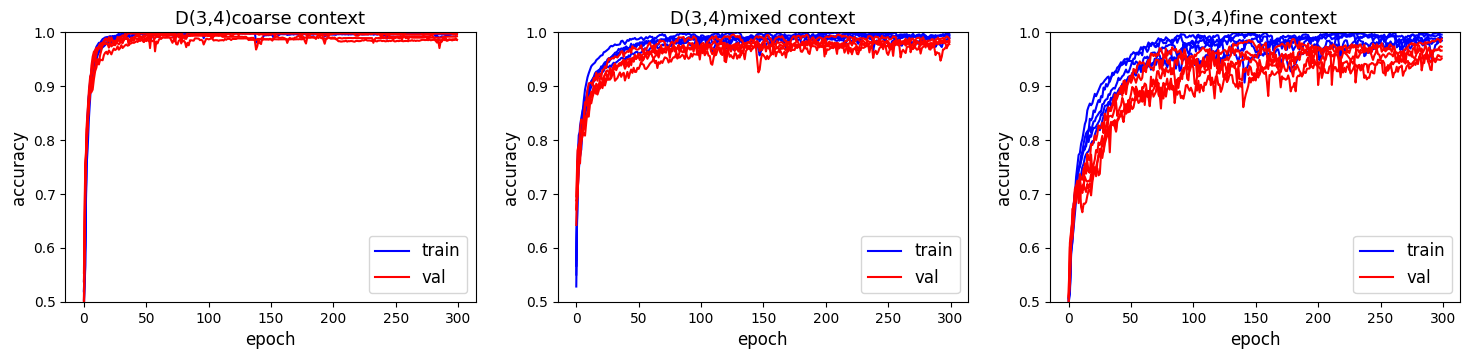

In [5]:
all_accuracies = load_accuracies(paths, n_runs=5, n_epochs=300, val_steps=1, granularities=True, zero_shot=False, context_unaware=context_unaware)

fig, axes = plt.subplots(1, 3, figsize=(18, 3.5))

for i, granularity in enumerate(granularity_list):
    plot_training_trajectory_new(all_accuracies[f'{granularity}_train_acc'], all_accuracies[f'{granularity}_val_acc'], 
                                ylim=(0.5, 1), steps=(1, 1), label=f'{granularity} context', ax=axes[i])


plt.show()

### Learning speed

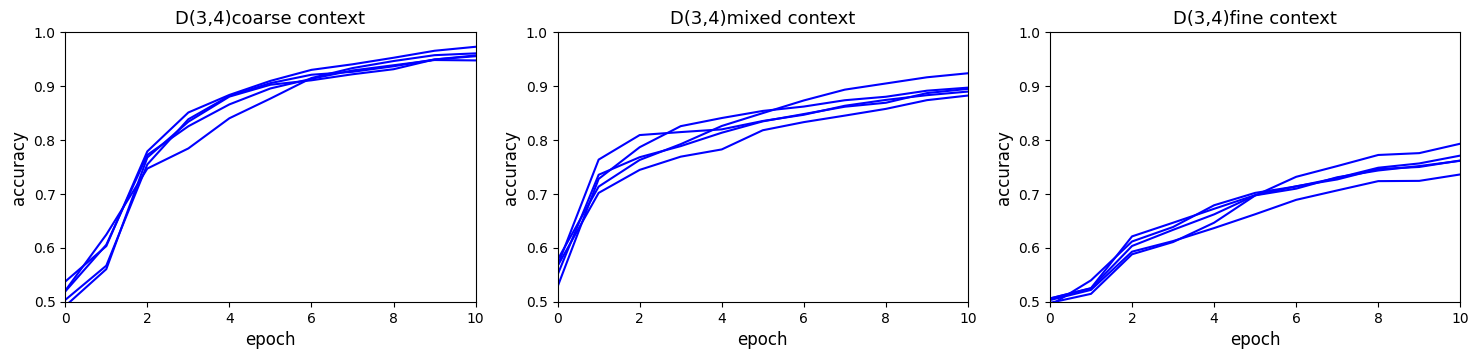

In [6]:

all_accuracies = load_accuracies(paths, n_runs=5, n_epochs=300, val_steps=1, granularities=True, zero_shot=False, context_unaware=context_unaware)

fig, axes = plt.subplots(1, 3, figsize=(18, 3.5))
for i, granularity in enumerate(granularity_list):
    plot_training_trajectory_new(all_accuracies[f'{granularity}_train_acc'], all_accuracies[f'{granularity}_val_acc'], 
                                ylim=(0.5, 1), xlim=(0, 10), steps=(1, 1), train_only=True, label=f'{granularity} context', ax=axes[i])

plt.show()


### Final accuracies 
Final accuracies heatmap plot + get accuracy means and sds for table representation.

In [7]:
##### heatmap for train and validation with different granularities:
all_accuracies = load_accuracies(paths, n_runs=5, n_epochs=300, granularities = granularities, val_steps=1, zero_shot=False)
accuracies_grans = []
test_accuracies_grans = []
if granularities:
    for g in granularity_list:
        accuracies_grans.append(all_accuracies[str(g)+'_train_acc'])
        accuracies_grans.append(all_accuracies[str(g)+'_val_acc'])
        test_accuracies_grans.append(all_accuracies[str(g)+'_test_acc'])

print('granularities',granularity_list)

granularities ['coarse', 'mixed', 'fine']


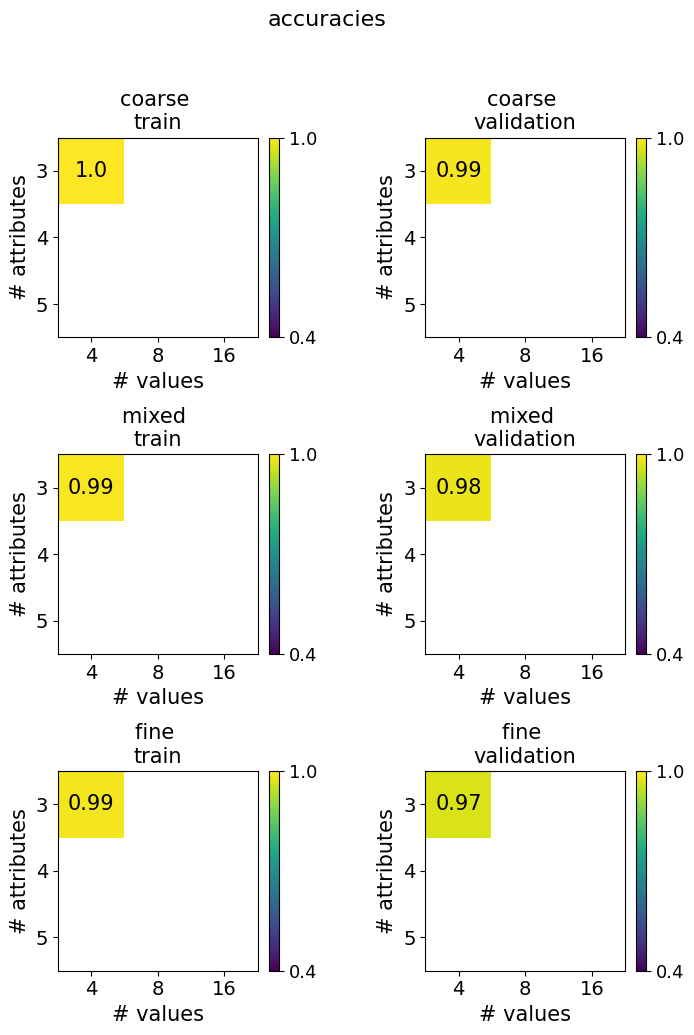

In [8]:
plot_grans_heatmap(accuracies_grans, 'mean', plot_dims=(3,2), ylims=(0.4, 1.0), granularity_list=granularity_list, figsize=(7.5, 10), matrix_indices=((0,0),), suptitle='accuracies', 
             fontsize=15)

In [9]:
for gran in granularity_list:
    print(gran + ' granularity: ')

    final_accuracies_train = {}
    final_accuracies_val = {}

    for i, d in enumerate(datasets):
        gather_train_accuracies = []
        gather_val_accuracies = []
        for run in range(5):
            gather_train_accuracies.append(all_accuracies[gran +'_train_acc'][i][run][-1])
            gather_val_accuracies.append(all_accuracies[gran +'_val_acc'][i][run][-1])

        final_accuracies_train[d] = (round(np.mean(gather_train_accuracies), 3), round(np.std(gather_train_accuracies), 3))
        final_accuracies_val[d] = (round(np.mean(gather_val_accuracies), 3), round(np.std(gather_val_accuracies), 3))

    print('final training accuracy:', final_accuracies_train)
    print('final validation accuracy',final_accuracies_val, '\n')


coarse granularity: 
final training accuracy: {'(3,4)': (0.999, 0.002)}
final validation accuracy {'(3,4)': (0.992, 0.005)} 

mixed granularity: 
final training accuracy: {'(3,4)': (0.993, 0.003)}
final validation accuracy {'(3,4)': (0.983, 0.004)} 

fine granularity: 
final training accuracy: {'(3,4)': (0.989, 0.004)}
final validation accuracy {'(3,4)': (0.966, 0.013)} 



#### Accuracies: Boostrapped CIs

In [10]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

# coarse (train, val), mixed (train, val), fine (train, val)
for i in range(len(accuracies_grans)):
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(accuracies_grans[i]) for _ in range(len(accuracies_grans[i]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    #for i in bootstrap_means:
    if i % 2 == 0:
        print('train ', end = '')
    elif  i % 2 == 1 :
        print('valid ', end = '')
    if i <= 1:
        print (granularity_list[0] + ': ',  end = '' )
    elif i <= 3 :
        print (granularity_list[1] + ': ', end = '')
    elif i >= 4 :
        print (granularity_list[2] + ': ',  end = '')

    print(f" Bootstrap Confidence Interval ({100*confidence_level}%): ({lower_percentile}, {upper_percentile}), Mean: {np.mean(bootstrap_means)}")

train coarse:  Bootstrap Confidence Interval (95.0%): (0.9914128048419952, 0.9914128048419952), Mean: 0.9914128048419957
valid coarse:  Bootstrap Confidence Interval (95.0%): (0.9863719634215037, 0.9914128048419952), Mean: 0.9888923841317498
train mixed:  Bootstrap Confidence Interval (95.0%): (0.9773852298259735, 0.9914128048419952), Mean: 0.9850566660298242
valid mixed:  Bootstrap Confidence Interval (95.0%): (0.9618952594995499, 0.9914128048419952), Mean: 0.9792663143972556
train fine:  Bootstrap Confidence Interval (95.0%): (0.9526425137321154, 0.9914128048419952), Mean: 0.9739415542642275
valid fine:  Bootstrap Confidence Interval (95.0%): (0.9144807227253914, 0.9914128048419952), Mean: 0.9640314156744216


### Test accuracies
means and stds

In [11]:
test_accuracies_grans

[array([[0.95899999, 0.95620006, 0.917     , 0.94440007, 0.9222002 ],
        [0.95899999, 0.95620006, 0.917     , 0.94440007, 0.9222002 ],
        [0.95899999, 0.95620006, 0.917     , 0.94440007, 0.9222002 ],
        [0.95899999, 0.95620006, 0.917     , 0.94440007, 0.9222002 ],
        [0.95899999, 0.95620006, 0.917     , 0.94440007, 0.9222002 ]]),
 array([[0.7956779 , 0.73432183, 0.80398303, 0.83171642, 0.75288135],
        [0.7956779 , 0.73432183, 0.80398303, 0.83171642, 0.75288135],
        [0.7956779 , 0.73432183, 0.80398303, 0.83171642, 0.75288135],
        [0.7956779 , 0.73432183, 0.80398303, 0.83171642, 0.75288135],
        [0.7956779 , 0.73432183, 0.80398303, 0.83171642, 0.75288135]]),
 array([[0.60280001, 0.66160005, 0.73200011, 0.59179991, 0.759     ],
        [0.60280001, 0.66160005, 0.73200011, 0.59179991, 0.759     ],
        [0.60280001, 0.66160005, 0.73200011, 0.59179991, 0.759     ],
        [0.60280001, 0.66160005, 0.73200011, 0.59179991, 0.759     ],
        [0.60280

In [ ]:
# first context-aware, then context-unaware
for cond in test_accuracies:
    for i, d in enumerate(datasets):
        print(d, round(np.mean(cond[i]), 3), round(np.std(cond[i]), 3), round(np.min(cond[i]), 2), round(np.max(cond[i]), 2))